In [ ]:
# Trained Brackish Dataset_(Split Ratio__Train= 11739, Test= 1467, Validation= 1468),  HpTn_Accuracy= 78.77% /  

# Data Augmentation ()

# N/A Regularization Elastic_Net (L1=0.0, L2=0.0)            [L1= Lasso Regression, L2= Riedge regression]

# Convolution_Layers Conv2D_( 328 --> 204 --> 248 --> 432 -->)         [Formation of Conv2D layers ]

# N/A Batch Normalization Conv2D_( /--> /--> /--> /--> /)    [ '/' it represents the application of Batch-Normalization]

# Dense_Layers ( 464 --> 176 --> 112 --> )          [Formation of Dense layers ]

# Dropout_Rate ( 464/0.1 , /0.0 , /0.0 )        ['/' it represents Dense_Layers  where Dropout rate Present]

# optimizers= Relu , Adam

# Learning_rate= 0.0003102 

# Input Shape= 224 , 224

# Batch-size= 64

# Padding= Same

# Strides= 1

# Epoch-size= 10/20/

In [2]:
# Imorting Libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,BatchNormalization,Dropout #Adding Batch Normalization & Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall

import keras_tuner
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
# loading Dataset Labels
train_labels = pd.read_csv('/kaggle/input/brackish-tf/Brackish 960x540.tensorflow/train/_annotations.csv')
test_labels = pd.read_csv('/kaggle/input/brackish-tf/Brackish 960x540.tensorflow/test/_annotations.csv')
valid_labels = pd.read_csv('/kaggle/input/brackish-tf/Brackish 960x540.tensorflow/valid/_annotations.csv')

In [5]:
# Specify target Image_size
image_width=224
image_height=224
batch_size=64

In [6]:
# Rescalling (Images )
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

In [7]:
# Converting Image to Array, Array to Image & Image Data Loading
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_labels,
    directory='/kaggle/input/brackish-tf/Brackish 960x540.tensorflow/train', # Specify the directory containing training images
    x_col='filename',                 # Name of the column containing filenames
    y_col='class',                                                                        # Name of the column containing labels
    target_size=(image_width, image_height),    # Resize images to the desired dimensions
    batch_size=batch_size,
    class_mode='categorical'               # Number of Classes in this case 'catagorical' means its detects  classes automatically
)

Found 28518 validated image filenames belonging to 6 classes.


In [8]:
# Image Data Loading from Test path
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_labels,
    directory='/kaggle/input/brackish-tf/Brackish 960x540.tensorflow/test',
    x_col='filename',
    y_col='class',
    target_size=(image_width, image_height),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 3466 validated image filenames belonging to 6 classes.


In [9]:
# Image Data Loading from Valid path
valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=valid_labels,
    directory='/kaggle/input/brackish-tf/Brackish 960x540.tensorflow/valid',
    x_col='filename',
    y_col='class',
    target_size=(image_width, image_height),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 3581 validated image filenames belonging to 6 classes.


In [10]:
# Define CNN Architecture (Brackish 5T_HpTn Weights)

model = Sequential([

    Conv2D(140, (3, 3), activation='relu', strides=1, padding='same', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),

    Conv2D(124, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(44, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    Conv2D(380, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Flatten(),

    Dense(460, activation='relu'),
    (Dropout(0.2)),

    Dense(56, activation='relu'),

    Dense(188, activation='relu'),

# Output layer with softmax activation for classification

    Dense(6, activation='softmax') 
])


learning_rate = 0.0003102     #  We Can Adjust this value for Adam Learning rate
optimizer = Adam(learning_rate=learning_rate)

# Define custom F1 score metric
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = Precision()
        self.recall = Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        p = self.precision.result()
        r = self.recall.result()
        return 2 * ((p * r) / (p + r + tf.keras.backend.epsilon()))

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [11]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 140)  │         3,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 140)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 110, 110, 124)  │       156,364 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 55, 55, 124)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 53, 53, 44)     │        49,148 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 44)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 380)    │       150,860 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 380)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 54720)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 460)            │    25,171,660 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 460)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 56)             │        25,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 188)            │        10,716 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │         1,134 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,569,618 (97.54 MB)

 Trainable params: 25,569,618 (97.54 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Compile the model with additional metrics
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy', Precision(), Recall(), F1Score()])

In [13]:
#Training of Model (takes 3.5 hours )
history = model.fit(train_generator, epochs=10, validation_data=valid_generator)

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1718140990.626665     386 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1718140990.647929     386 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 57/446 ━━━━━━━━━━━━━━━━━━━━ 1:52 290ms/step - accuracy: 0.2896 - f1_score: 0.0206 - loss: 1.5305 - precision: 0.2837 - recall: 0.0109

W0000 00:00:1718141037.398505     385 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


446/446 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step - accuracy: 0.3655 - f1_score: 0.0938 - loss: 1.4073 - precision: 0.4652 - recall: 0.0565

W0000 00:00:1718141151.948249     385 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


446/446 ━━━━━━━━━━━━━━━━━━━━ 250s 440ms/step - accuracy: 0.3657 - f1_score: 0.0944 - loss: 1.4068 - precision: 0.4658 - recall: 0.0569 - val_accuracy: 0.7182 - val_f1_score: 0.6909 - val_loss: 0.7540 - val_precision: 0.7829 - val_recall: 0.6183
Epoch 2/10


W0000 00:00:1718141186.613406     387 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


446/446 ━━━━━━━━━━━━━━━━━━━━ 144s 319ms/step - accuracy: 0.7266 - f1_score: 0.7149 - loss: 0.6977 - precision: 0.7683 - recall: 0.6685 - val_accuracy: 0.7612 - val_f1_score: 0.7594 - val_loss: 0.5762 - val_precision: 0.7824 - val_recall: 0.7378
Epoch 3/10
446/446 ━━━━━━━━━━━━━━━━━━━━ 145s 320ms/step - accuracy: 0.7669 - f1_score: 0.7615 - loss: 0.5640 - precision: 0.7933 - recall: 0.7322 - val_accuracy: 0.7744 - val_f1_score: 0.7698 - val_loss: 0.5341 - val_precision: 0.8041 - val_recall: 0.7383
Epoch 4/10
446/446 ━━━━━━━━━━━━━━━━━━━━ 144s 318ms/step - accuracy: 0.7738 - f1_score: 0.7688 - loss: 0.5244 - precision: 0.8005 - recall: 0.7396 - val_accuracy: 0.7827 - val_f1_score: 0.7809 - val_loss: 0.4925 - val_precision: 0.8058 - val_recall: 0.7576
Epoch 5/10
446/446 ━━━━━━━━━━━━━━━━━━━━ 144s 318ms/step - accuracy: 0.7850 - f1_score: 0.7829 - loss: 0.4976 - precision: 0.8111 - recall: 0.7566 - val_accuracy: 0.7783 - val_f1_score: 0.7616 - val_loss: 0.5150 - val_precision: 0.8329 - val_re

In [14]:
# Evaluate the model
test_loss, test_accuracy, test_precision, test_recall, test_f1_score = model.evaluate(valid_generator)
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")
print(f"Test F1 Score: {test_f1_score}")

56/56 ━━━━━━━━━━━━━━━━━━━━ 15s 261ms/step - accuracy: 0.7804 - f1_score: 0.7777 - loss: 0.4791 - precision: 0.8195 - recall: 0.7401
Test Accuracy: 0.788885772228241
Test Precision: 0.8214176297187805
Test Recall: 0.7475565671920776
Test F1 Score: 0.7827485203742981


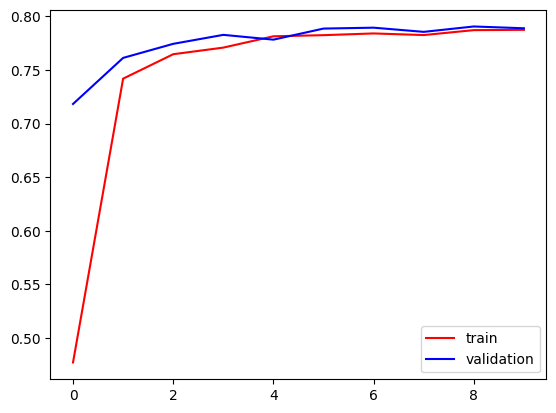

In [15]:
# Ploting Accuracy Graph

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

In [16]:
# Ploting Loss Graph
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

In [17]:
# Ploting Precision Graph
plt.plot(history.history['precision'],color='Green',label='train')
plt.plot(history.history['val_precision'],color='red',label='validation')
plt.legend()
plt.show()

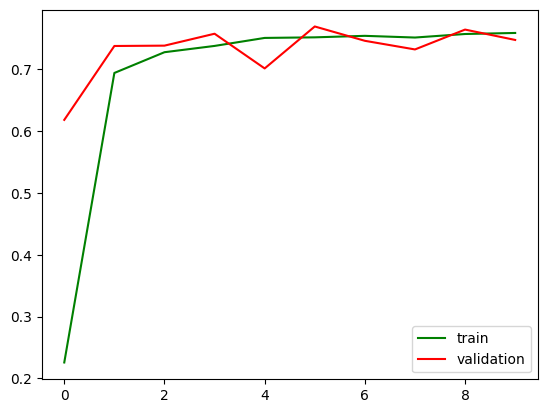

In [18]:
# Ploting Recall Graph
plt.plot(history.history['recall'],color='Green',label='train')
plt.plot(history.history['val_recall'],color='red',label='validation')
plt.legend()
plt.show()

In [19]:
# Ploting F1 Score Graph
plt.plot(history.history['f1_score'],color='Green',label='train')
plt.plot(history.history['val_f1_score'],color='red',label='validation')
plt.legend()
plt.show()

In [20]:
#Saving the Model
model.save('5T_Brackish(78.88%).h5')

In [ ]:
#Training of Model (takes 3.5 hours )
history = model.fit(train_generator, epochs=20, validation_data=valid_generator)

In [ ]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(valid_generator)
print(f"Test Accuracy: {test_accuracy}")

In [ ]:
# Ploting Accuracy Graph

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

In [ ]:
# Ploting Loss Graph
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

In [ ]:
#Saving the Model
model.save('5T_Brackish(79.47%).h5')